In [3]:
from imutils import *

In [49]:
os.system('pip -q install albumentations')
from albumentations import ( Normalize, Resize, GaussNoise,RandomBrightnessContrast, CenterCrop, HueSaturationValue, GaussianBlur, CenterCrop)
from albumentations.pytorch import ToTensor
from albumentations import Compose

In [3]:
data = pd.read_csv('train.csv')
data.head()

NameError: name 'pd' is not defined

In [51]:
image_ids = data['ImageId'].unique().tolist()
train_count = 570
val_count = len(image_ids) - train_count
print('The no. of images in training data is: %d\nThe no. of images in validation data is: %d'%(train_count, val_count))
train_ids = image_ids[:train_count]
val_ids = image_ids[train_count:]

The no. of images in training data is: 570
The no. of images in validation data is: 100


In [5]:
train_dir = '/storage/train/'
val_dir = '/storage/train/'

In [53]:
def get_image(root_dir, image_id):
    img_add = root_dir +image_id + '/' +  'images/' + image_id + '.png'
    img = Image.open(img_add)
    return np.array(img)[:, :, :-1]   

def get_mask(root_dir, image_id, shape = 256):
    mask_dir = root_dir +image_id + '/' +  'masks/'
    mask = np.zeros((shape, shape))
    for _, _, files in os.walk(mask_dir):
        for file in files :
            if 'checkpoint' not in file:
                img = Image.open(mask_dir + file)
                img = CenterCrop(256, 256)(image = np.array(img))['image']
                mask += img/255
    return np.array(mask)

(<matplotlib.image.AxesImage at 0x7f8eb6108ac8>, (256, 256, 3))

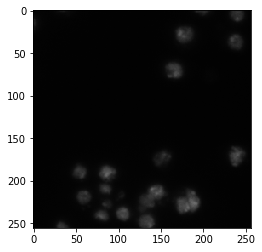

In [54]:
im_id = image_ids[0]
sample_img = get_image(train_dir, im_id)
plt.imshow(sample_img), sample_img.shape

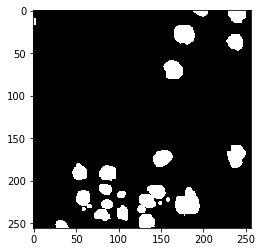

In [55]:
sample_mask = get_mask(train_dir, im_id)
plt.imshow(sample_mask, cmap = 'gray')

In [56]:
class dataset(Dataset):
    def __init__(self, root_dir,im_ids,  mode = 'train'):
        super(dataset, self).__init__()
        self.root_dir = root_dir
        self.trans = None
        self.im_ids = im_ids
        if mode == 'train':
            self.trans = Compose([ GaussNoise(),
                                   RandomBrightnessContrast(), 
                                   HueSaturationValue(),
                                   GaussianBlur(),
                                   CenterCrop(256, 256),
                                   Normalize(),
                                   ToTensor()
                                 ])
        else:
            self.trans = Compose([Normalize(),
                                  CenterCrop(256, 256),
                               ToTensor()
                             ]) 
        
    def __len__(self):
        return len(self.im_ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        im_id = self.im_ids[idx]
        img = get_image(self.root_dir, im_id)
        img = self.trans(image = img)['image']
        mask = get_mask(self.root_dir, im_id)
        return img, torch.from_numpy(mask)
            

In [57]:
train_data = dataset(train_dir, train_ids, mode = 'train')
val_data = dataset(train_dir, val_ids, mode = 'val')

In [58]:
class DiceLoss(torch.nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc


In [59]:
img, mask = train_data[np.random.randint(500)]
img.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [60]:
unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32)
device = torch.device('cuda' )
unet.load_state_dict(torch.load('unet.pt'))
unet = unet.to(device)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [61]:
loss_fn = DiceLoss()
adam = Adam(unet.parameters(), lr = 5e-4)
lr_sched = reducer(adam, factor = 0.33, patience = 3)

In [62]:
train_loader = DataLoader(train_data, shuffle = True, batch_size =32 )
val_loader = DataLoader(val_data, shuffle = True, batch_size = 32)

In [63]:
device

device(type='cuda')

In [37]:
num_epoch = 15
train_loss_list = []
val_loss_list = []


In [39]:
num_epoch = 10

💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙Traing Started💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙
Starting epoch 61
Epoch:     1 Train loss: 0.46315  Val loss: 0.27192

Starting epoch 62
Epoch:     2 Train loss: 0.41987  Val loss: 0.22445

Starting epoch 63
Epoch:     3 Train loss: 0.39610  Val loss: 0.23769

Starting epoch 64
Epoch:     4 Train loss: 0.39960  Val loss: 0.35649

Starting epoch 65
Epoch:     5 Train loss: 0.38002  Val loss: 0.23256

Training completed 
 train loss 0.380 
Val loss: 0.233


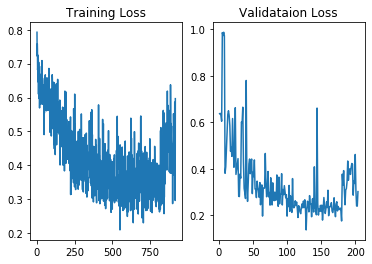

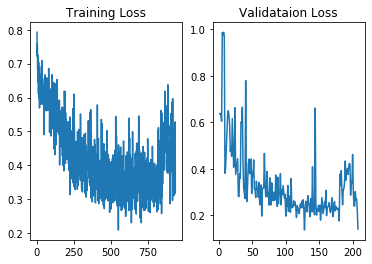

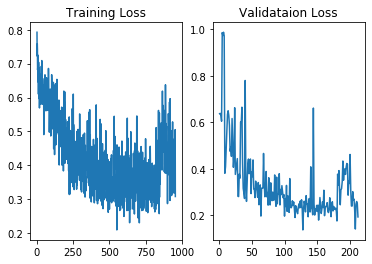

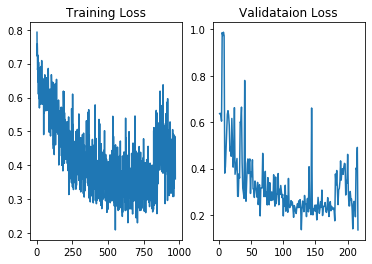

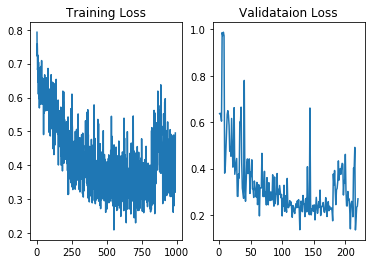

In [66]:
print('💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙Traing Started💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙')
for epoch in range(num_epoch):
    print('Starting epoch %d'%(epoch + 61))
    os.system('clear')
    train_loss = 0
    val_loss = 0
    unet.train()
    for batch, (img, mask) in enumerate(train_loader):
        img = img.to(device)
        mask = mask.unsqueeze(1).type('torch.FloatTensor').to(device)
        scores = unet(img)
        loss = loss_fn(scores, mask)
        loss.backward()
        adam.step()
        train_loss += loss.item()
        train_loss_list.append(loss.item())
    train_loss /= (batch + 1)
    with torch.no_grad():
        unet.eval()
        for batch, (img, mask) in enumerate(val_loader):
            img = img.to(device)
            mask = mask.unsqueeze(1).type('torch.FloatTensor').to(device)
            scores = unet(img)
            loss = loss_fn(scores, mask)
            val_loss += loss.item()
            val_loss_list.append(loss.item())
        val_loss /= (batch + 1)
    lr_sched.step(val_loss)
    print('Epoch: %5d Train loss: %.5f  Val loss: %.5f\n'%(epoch + 1, train_loss, val_loss))
    if val_loss< prev_loss:
        prev_loss = val_loss
        torch.save(unet.state_dict(), 'unet.pt')
    fig, ax = plt.subplots(1, 2)
    ax[0].set_title('Training Loss')
    ax[1].set_title('Validataion Loss')
    ax[0].plot(np.arange(len(train_loss_list))+1, train_loss_list)
    ax[1].plot(np.arange(len(val_loss_list))+1, val_loss_list)
print('Training completed \n train loss %.3f \nVal loss: %.3f'%(train_loss, val_loss))

In [45]:
prev_loss = val_loss

In [65]:
prev_loss

0.21235434710979462

In [1]:
from imutils import *


In [3]:
31096972/1024/1024

29.656383514404297